In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
from torch.autograd import Variable
import tensorflow as tf
import torch

In [2]:
import matplotlib.font_manager as fm

font_list = fm.findSystemFonts(fontpaths = None, fontext = 'ttf')
font_list[:]

['C:\\Windows\\Fonts\\seguisli.ttf',
 'C:\\WINDOWS\\Fonts\\VINERITC.TTF',
 'C:\\Windows\\Fonts\\OLDENGL.TTF',
 'C:\\Windows\\Fonts\\PERI____.TTF',
 'C:\\Windows\\Fonts\\LBRITED.TTF',
 'C:\\WINDOWS\\Fonts\\BOD_BLAR.TTF',
 'C:\\WINDOWS\\Fonts\\georgiaz.ttf',
 'C:\\WINDOWS\\Fonts\\RAVIE.TTF',
 'C:\\Windows\\Fonts\\ERASBD.TTF',
 'C:\\Windows\\Fonts\\mmrtextb.ttf',
 'C:\\Windows\\Fonts\\BRLNSB.TTF',
 'C:\\Windows\\Fonts\\Hancom HMJE_V.ttf',
 'C:\\Windows\\Fonts\\seguibl.ttf',
 'C:\\Windows\\Fonts\\ariali.ttf',
 'C:\\Windows\\Fonts\\BELLB.TTF',
 'C:\\WINDOWS\\Fonts\\GIL_____.TTF',
 'C:\\Windows\\Fonts\\CENTAUR.TTF',
 'C:\\Windows\\Fonts\\REFSPCL.TTF',
 'C:\\WINDOWS\\Fonts\\micross.ttf',
 'C:\\Windows\\Fonts\\LBRITEDI.TTF',
 'C:\\Windows\\Fonts\\TCM_____.TTF',
 'C:\\Windows\\Fonts\\bahnschrift.ttf',
 'C:\\WINDOWS\\Fonts\\ariali.ttf',
 'C:\\WINDOWS\\Fonts\\TCCB____.TTF',
 'C:\\WINDOWS\\Fonts\\NGULIM.TTF',
 'C:\\Windows\\Fonts\\RAGE.TTF',
 'C:\\Windows\\Fonts\\mmrtext.ttf',
 'C:\\Windows\\Fonts

In [3]:
#방법 1
import matplotlib
import matplotlib.font_manager as fm

import os


# Mac OS의 경우와 그 외 OS의 경우로 나누어 설정

if os.name == 'posix':

    plt.rc("font", family="AppleGothic")

else:

    plt.rc("font", family="Malgun Gothic")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch import optim
# 데이터 불러오기
df_all=pd.read_csv('../data_v3/감성점수와 일별뉴스 합친거.csv',encoding='utf-8')
df = df_all.iloc[:,[1,2,5]]

In [5]:

df_all=pd.read_excel('../data_v3/전국경락단가.xlsx')
df['경락단가_평균']=df_all['price']
df['경락단가']=df_all['price']
df_all

df.columns=['도매가격_1', '도매가격', 'day_sentiment']

df

C:\Users\jaemin\Anaconda3\envs\jm\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  """Entry point for launching an IPython kernel.


,도매가격_1,도매가격,day_sentiment
0,4104,4104,0.000000
1,4049,4049,0.000000
2,3920,3920,-0.104167
3,3917,3917,-0.104167
4,4090,4090,-0.104167
...,...,...,...
620,4718,4718,0.175000
621,4749,4749,-0.116270
622,4820,4820,-0.116270
623,4919,4919,-0.116270


In [6]:
#df=df[['day_sentiment','경락단가_평균']]
df=df[['도매가격_1','day_sentiment','도매가격']]

df.head()

,도매가격_1,day_sentiment,도매가격
0,4104,0.000000,4104
1,4049,0.000000,4049
2,3920,-0.104167,3920
3,3917,-0.104167,3917
4,4090,-0.104167,4090


In [7]:
sequence_in=5
sequence_out=20
global input_size 
input_size=2

In [8]:
# scale the data 
from sklearn.preprocessing import MinMaxScaler 
sc = MinMaxScaler(feature_range=(0,1))
sc2=MinMaxScaler(feature_range=(0,1))

In [9]:
def ts_train_test_normalize(all_data, time_steps, for_periods):
    """
    input: 
        data: dataframe with dates and price data
    output: 
        X_train, y_train: data from 2013/1/1-2018/12/31 
        X_test : data from 2019- 
        sc :     insantiated MinMaxScaler object fit to the training data 
    """
    # create training and test set 
    # 데이터를 역순으로 정렬하여 전체 데이터의 70% 학습, 30% 테스트에 사용
    train_size = int(len(all_data)*0.7)
    ts_train = all_data[0:train_size]  
    ts_test = all_data[train_size:]
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
    #x_inputSize=2
    
#     # scale the data 
#     from sklearn.preprocessing import MinMaxScaler 
#     sc = MinMaxScaler(feature_range=(0,1))
#     sc2=MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)
    
    # create training data of s samples and t time steps 
    X_train = [] 
    y_train = [] 
    for i in range(time_steps, ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i, 0:input_size])
        if len(ts_train_scaled[i:i+for_periods, 0])!=sequence_out:
            #new_list=[]
            alist=ts_train_scaled[i:i+for_periods, 0]
            alist = np.concatenate((alist, np.array([alist[-1]] * (sequence_out- len(ts_train_scaled[i:i+for_periods, 0])))))
            y_train.append(alist)
            alist=[]
            #new_list=[]
        else:
            y_train.append(ts_train_scaled[i:i+for_periods, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # Reshaping X_train for efficient modelling 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], input_size ))
    inputs = pd.concat((all_data[['도매가격','day_sentiment']][0:train_size], all_data[['도매가격','day_sentiment']][train_size:]), axis=0).values
    inputs2 = pd.concat((all_data['도매가격'][0:train_size], all_data['도매가격'][train_size:]), axis=0).values
    inputs = inputs[len(inputs)-len(ts_test)-time_steps:]
    inputs = sc.fit_transform(inputs)
    inputs = inputs.reshape(-1,input_size)
    
    inputs2 = inputs2[len(inputs)-len(ts_test)-time_steps:]
    inputs2 = sc2.fit_transform(inputs2.reshape(-1,1))
    inputs2=inputs.reshape(-1,1)
    # Preparing X_test 
    X_test = [] 
    y_test = [] 
    for i in range(time_steps, ts_test_len + time_steps - for_periods):
        X_test.append(inputs[i-time_steps:i,0:input_size])
        y_test.append(inputs2[i:i+for_periods, 0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], input_size))
    
    return X_train, y_train , X_test,y_test, sc 

In [10]:
X_train, y_train, X_test, y_test,sc = ts_train_test_normalize(df, sequence_in,sequence_out)
X_train.shape[0], X_train.shape[1]

(431, 5)

In [11]:
y_test.shape

(168, 20)

In [12]:
# # Convert the 3D shape of X_train to a data frame so we can see: 
# X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1],input_size)))
# y_train_see = pd.DataFrame(y_train)
# pd.concat([X_train_see, y_train_see], axis = 1)

# # Convert the 3D shape of X_test to a data frame so we can see: 
# X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1],input_size)))
# pd.DataFrame(X_test_see)

# print("There are " + str(X_train.shape[0]) + " samples in the training data")
# print("There are " + str(X_test.shape[0]) + " samples in the test data")

### 모델링

In [13]:
def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras.optimizers import SGD
    global input_size 
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 10, 
                           return_sequences = True, 
                           input_shape = (X_train.shape[1],input_size), 
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 10, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=sequence_out))
    
    # Compiling 
    my_LSTM_model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
    print("X_train",X_train.shape)
    print("y_train",y_train.shape)
    # Fitting to the training set 
    my_LSTM_model.fit(X_train, y_train, epochs = 100, batch_size = 100, verbose = 0)
    LSTM_prediction = my_LSTM_model.predict(X_test)
    #LSTM_prediction = np.concatenate((LSTM_prediction, np.array([LSTM_prediction[-1]] * 5)))
    print('LSTM_prediction',LSTM_prediction.shape)
    LSTM_prediction = sc2.inverse_transform(LSTM_prediction)
    
    return my_LSTM_model, LSTM_prediction 

In [14]:
def actual_pred_plot(preds):
    """
    Plot the actual vs prediction
    """
    actual_pred = pd.DataFrame(columns = ['도매가격', 'prediction'])
    actual_pred['도매가격'] = df.loc[int(len(df)*0.7):,'도매가격'][0:len(preds)]
    #actual_pred['prediction'] = preds[:,0]
    actual_pred['prediction']  = np.mean(preds, axis=1)
    from keras.metrics import MeanSquaredError 
#     m = MeanSquaredError()
#     m.update_state(np.array(actual_pred['도매가격']), np.array(actual_pred['prediction']))
    return (actual_pred.plot())

In [15]:
#LSTM_prediction[:,0].shape

X_train (431, 5, 2)
y_train (431, 20)
LSTM_prediction (168, 20)


<AxesSubplot:>

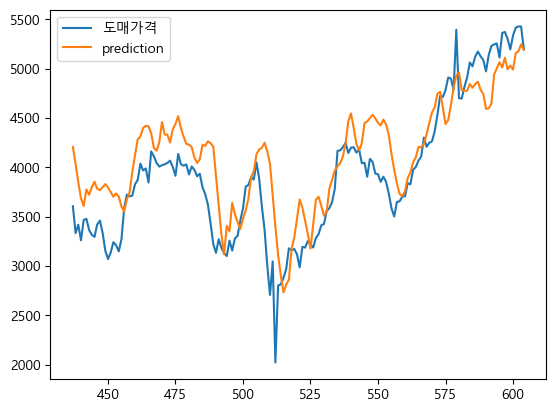

In [16]:
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[:]
actual_pred_plot(LSTM_prediction)

In [17]:
y_pred = pd.DataFrame(np.mean(LSTM_prediction, axis=1))
y_test=df.loc[int(len(df)*0.7):,'도매가격'][0:len(LSTM_prediction)]
y_test.reset_index(drop=True, inplace=True)

In [18]:
def mape(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
# MAPE(y_test, y_pred)[0]

In [19]:
LSTM_prediction

array([[4255.0894, 4250.1475, 4265.54  , ..., 4142.1094, 4150.904 ,
        4100.3027],
       [4075.303 , 4071.9788, 4078.9595, ..., 3993.5159, 3981.254 ,
        3936.8333],
       [3881.0852, 3884.8047, 3884.1914, ..., 3828.1638, 3796.5857,
        3762.7183],
       ...,
       [5700.321 , 5663.1665, 5831.473 , ..., 4758.1714, 4688.549 ,
        4664.6533],
       [5778.384 , 5757.846 , 5934.749 , ..., 4795.2095, 4722.009 ,
        4716.4355],
       [5715.9624, 5694.7837, 5855.667 , ..., 4732.1006, 4683.911 ,
        4678.72  ]], dtype=float32)

In [20]:
y_pred

,0
0,4207.117676
1,4034.440186
2,3848.932861
3,3685.399658
4,3608.899658
...,...
163,4991.986328
164,5157.016602
165,5177.063477
166,5247.799805


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    MSE=mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MSLE = mean_squared_log_error(y_test, y_pred)
    MAPE=mape(y_test, y_pred)[0]
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    
    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[MAE,MSE,RMSE,MAPE ,RMSLE, R2],
                         index = ['MAE','MSE','RMSE', 'MAPE','RMSLE', 'R2'],
                         columns=['Results'])
    return Result



In [22]:
confirm_result(y_test, y_pred)

,Results
MAE,313.05567
MSE,156017.88387
RMSE,394.99099
MAPE,16.90709
RMSLE,0.10805
R2,0.67566
